导入库

In [1]:

import tensorflow as tf
import numpy as np
import mnist_data
import os
# import beta_vae as vae
import vae
import plot_utils
import glob
import random
import matplotlib.pyplot as plt
import cv2

配置参数

In [2]:
#gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#图像尺寸
IMAGE_SIZE_MNIST = 28
#隐变量维度
dim_z=20
#隐层节点数
n_hidden=500
#学习率
learn_rate=1e-3
#训练轮数
n_epochs=10
#批量数目
batch_size=128
#标签样式 one-hot编码
one_hot=np.eye(10)
#结果保存路径
path=os.path.join(os.getcwd(),'result')
if not os.path.exists(path):
    os.system('mkdir '+path)
RESULTS_DIR=path
#是否加入噪声，denoise vae
ADD_NOISE=False
dim_img = IMAGE_SIZE_MNIST**2
#beta-vae
beta=2.0
#画图
PRR=True
PRR_n_img_x=10
PRR_n_img_y=10
PRR_resize_factor=1.0
PMLR=False
PMLR_n_img_x=20
PMLR_n_img_y=20
PMLR_resize_factor=1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

准备new domain数据

In [3]:
#固定随机因子
random.seed(100)
#印刷体mnist数据
newdata_path=os.path.join(os.getcwd(),'mnist/pr')
#训练数据比例
propotion=0.7
imlist=os.listdir(newdata_path)
#印刷体mnist数据训练集样本数
train_font_size=int(len(imlist)*0.7)
random.shuffle(imlist)
trainlist=imlist[:train_font_size]
testlist=imlist[train_font_size:]
#印刷体mnist数据测试集样本数
test_font_size=len(testlist)
#训练集数组，包含样本内容和标签
train_font_data=np.zeros([train_font_size,794])
#测试集数组，只包含数据内容
test_font_data=np.zeros([test_font_size,784])
#测试集标签
test_font_labels=np.zeros([test_font_size,10])
c=0
for im in trainlist:
    label=int(im.split('_')[0])
    img=cv2.imread(newdata_path+'/'+im,0).reshape(784)/255.0
    train_font_data[c]=np.concatenate([img,one_hot[label]])
    c+=1
    
c=0
for im in testlist:
    label=int(im.split('_')[0])
    img=cv2.imread(newdata_path+'/'+im,0).reshape(784)/255.0
    test_font_data[c]=img
    test_font_labels[c]=one_hot[label]
    c+=1


检验数据

 训练集
标签编码： [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


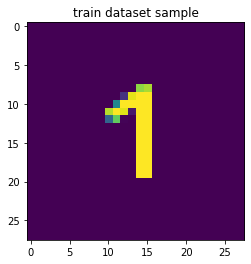

In [4]:
print(' 训练集')
plt.title('train dataset sample')
plt.imshow(train_font_data[1,:-10].reshape([28,28]))
print('标签编码：',train_font_data[1,-10:])


 测试集
标签编码： [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


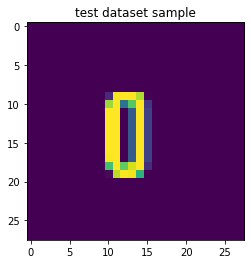

In [5]:
print(' 测试集')
plt.title('test dataset sample')
plt.imshow(test_font_data[1].reshape([28,28]))
print('标签编码：',test_font_labels[1])

准备target domain 数据

In [6]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()

W0916 10:48:42.950549 140666206533440 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/mnist_data.py:30: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.



Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


 训练集
标签编码： [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


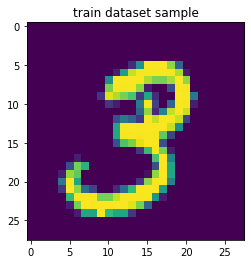

In [7]:
print(' 训练集')
plt.title('train dataset sample')
plt.imshow(train_total_data[1,:-10].reshape([28,28]))
print('标签编码：',train_total_data[1,-10:])

 测试集
标签编码： [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


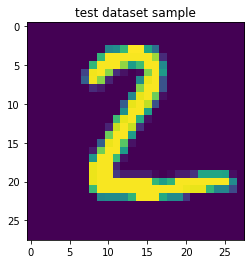

In [8]:
print(' 测试集')
plt.title('test dataset sample')
plt.imshow(test_data[1].reshape([28,28]))
print('标签编码：',test_labels[1])

target domain 测试集平均脸

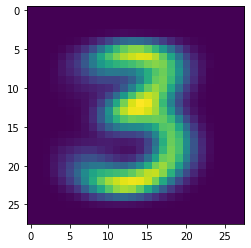

In [9]:
#p=test_font_data.reshape([-1,28,28])
pq=np.zeros([28,28])
c=0
for p in range(test_data.shape[0]):
    if np.argmax(test_labels[p])==3:
        pq+=test_data[p].reshape([28,28])
        c+=1
plt.imshow(pq/c)

选定一个类别，为vector arithmetic测试，准备数据

例如：针对类别3，将new domain数据中类别3的样本组成数组，

target domain数据中类别3的样本组成数组

target domain test count


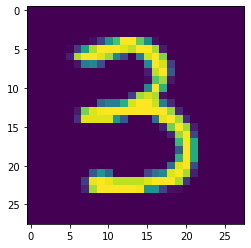

target domain 5638
new domain test count


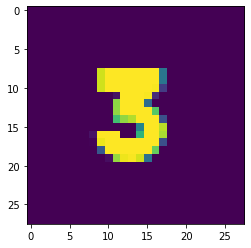

new domain 355
target domain test data


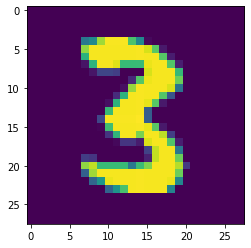

new domain test data


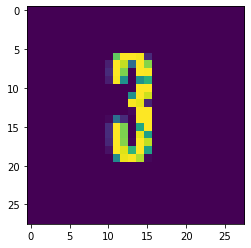

In [10]:
c=0
for p in range(train_total_data.shape[0]):
    if np.argmax(train_total_data[p,-10:])==3:
        c+=1
#         print(c)
        if c == 10:
#             print(c)
            print('target domain test count')
            plt.imshow(train_total_data[p,:-10].reshape([28,28]))
            plt.show()
target_domain_size=c
print('target domain',target_domain_size)

c=0
for p in range(train_font_data.shape[0]):
    if np.argmax(train_font_data[p,-10:])==3:
        c+=1
        if c==10:
            print('new domain test count')
            plt.imshow(train_font_data[p,:-10].reshape([28,28]))
            plt.show()
original_domain_size=c
print('new domain',original_domain_size)

k3=np.zeros([target_domain_size,784])
c=0
for p in range(train_total_data.shape[0]):
    if np.argmax(train_total_data[p,-10:])==3:
        k3[c]=train_total_data[p,:-10]
        c+=1
        if c==30:
            print('target domain test data')
            plt.imshow(train_total_data[p,:-10].reshape([28,28]))
            plt.show()

k3_n=np.zeros([original_domain_size,784])
c=0
for p in range(train_font_data.shape[0]):
    if np.argmax(train_font_data[p,-10:])==3:
        k3_n[c]=train_font_data[p,:-10]
        c+=1
        if c==30:
            print('new domain test data')
            plt.imshow(train_font_data[p,:-10].reshape([28,28]))
            plt.show()

In [11]:
#设置两个 domain 的batch size
target_batch = int(target_domain_size / batch_size)
original_batch = int(original_domain_size / batch_size)

In [12]:

""" build graph """
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

#vae
y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)

# network architecture beta vae
# y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob,beta)

# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

decoded = vae.decoder(z_in, dim_img, n_hidden)

W0916 10:48:45.616662 140666206533440 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:5: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0916 10:48:46.713024 140666206533440 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0916 10:48:46.715425 140666206533440 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:11: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0916 10:48:46.733060 140666206533440 deprecation.py:506] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:15: calling dropout (from tensorflow.python.ops.nn_op

In [13]:
#两个domain数据一起训练vae
test_2domain_data=np.concatenate([test_data,test_font_data],axis=0)
np.random.seed(100)
np.random.shuffle(test_2domain_data)
test_labels=test_font_labels
train_size=train_font_size+train_size
test_data=test_2domain_data
n_samples=train_size
#同一类别在两个domain的隐变量的平均
vec_ari_a=np.zeros([1,dim_z])
vec_ari_b=np.zeros([1,dim_z])

""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99
sess=tf.Session()
# with tf.Session() as sess:

sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for epoch in range(n_epochs):

    # Random shuffling
#         np.random.shuffle(train_total_data)
#         train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS]
#         np.random.shuffle(train_font_data)
#         train_data_ = train_font_data[:, :-mnist_data.NUM_LABELS]
    train_2domain_data=np.concatenate([train_total_data,train_font_data],axis=0)
    np.random.shuffle(train_2domain_data)
    train_data_ = train_2domain_data[:, :-mnist_data.NUM_LABELS]

    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (n_samples)
        batch_xs_input = train_data_[offset:(offset + batch_size), :]

        batch_xs_target = batch_xs_input

        # add salt & pepper noise
        if ADD_NOISE:
            batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
            batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

        _, tot_loss, loss_likelihood, loss_divergence = sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence),
            feed_dict={x_hat: batch_xs_input, x: batch_xs_target, keep_prob : 0.9})

    # print cost every epoch
    print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))

    # if minimum loss is updated or final epoch, plot results
    if min_tot_loss > tot_loss or epoch+1 == n_epochs:
        min_tot_loss = tot_loss
        # Plot for reproduce performance
        if PRR:
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
            y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

        # Plot for manifold learning result
        if PMLR and dim_z == 2:
            y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
            y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

            # plot distribution of labeled images
            z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
            PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")


epoch 0: L_tot 129.12 L_likelihood 105.13 L_divergence 23.99
epoch 1: L_tot 122.53 L_likelihood 98.69 L_divergence 23.84
epoch 2: L_tot 116.64 L_likelihood 92.30 L_divergence 24.34
epoch 3: L_tot 116.14 L_likelihood 92.37 L_divergence 23.76
epoch 4: L_tot 115.68 L_likelihood 91.49 L_divergence 24.19
epoch 5: L_tot 110.69 L_likelihood 86.94 L_divergence 23.75
epoch 6: L_tot 111.49 L_likelihood 87.83 L_divergence 23.66
epoch 7: L_tot 110.53 L_likelihood 87.61 L_divergence 22.92
epoch 8: L_tot 109.74 L_likelihood 86.16 L_divergence 23.58
epoch 9: L_tot 110.82 L_likelihood 86.87 L_divergence 23.95


In [14]:
###-----vector arithmetic-----###
for offset in range(target_batch):
    x_batch=k3[offset*batch_size:(offset+1)*batch_size]
    z_batch = sess.run(z, feed_dict={x_hat: x_batch, keep_prob : 1})
    vec_ari_a+=np.sum(z_batch,axis=0)
vec_ari_a=vec_ari_a*1.0/(target_batch*batch_size)

for offset in range(original_batch):
    x_batch=k3_n[offset*batch_size:(offset+1)*batch_size]
    z_batch = sess.run(z, feed_dict={x_hat: x_batch, keep_prob : 1})
    vec_ari_b+=np.sum(z_batch,axis=0)
vec_ari_b=vec_ari_b*1.0/(original_batch*batch_size)

vec_ari_c=vec_ari_a-vec_ari_b



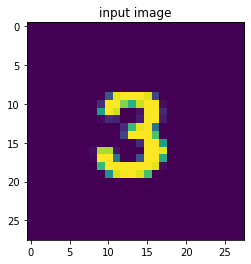

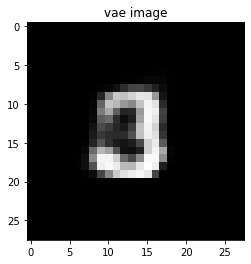

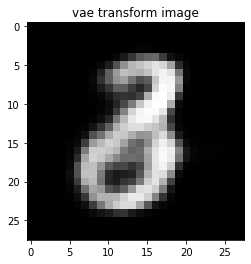

In [17]:
plt.title('input image')
# plt.subplots(131)
plt.imshow(k3_n[5].reshape([28,28]))
plt.show()
x_sample=k3_n[5].reshape([1,-1])

#     plt.imshow(k3_n[2].reshape([28,28]))
z_sample = sess.run(z, feed_dict={x_hat: x_sample, keep_prob : 1})
#     y_PMLR = sess.run(y, feed_dict={x_hat: x_sample, keep_prob : 1})
y_PMLR = sess.run(decoded, feed_dict={z_in: z_sample, keep_prob : 1})
np.clip(y_PMLR,1e-8, 1 - 1e-8,out=y_PMLR)
plt.title('vae image')
# plt.subplots(132)
plt.imshow(y_PMLR.reshape([28,28]),cmap='gray')
plt.show()

y_PMLR = sess.run(decoded, feed_dict={z_in: z_sample+vec_ari_c, keep_prob : 1})
np.clip(y_PMLR,1e-8, 1 - 1e-8,out=y_PMLR)

plt.title('vae transform image')
# plt.subplots(133)
plt.imshow(y_PMLR.reshape([28,28]),cmap='gray')
plt.show()
